In [51]:
from aquabyte.data_access_utils import RDSAccessUtils, S3AccessUtils
import json
import os
import  pandas as pd
from aquabyte.visualize import Visualizer
import matplotlib.patches as patches
from tqdm import tqdm
from utils import utils

import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [4]:
%matplotlib inline

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import randint, seed

In [5]:
SEED = 33
CROP_WIDTH = 512
CROP_HEIGHT = 512


LABEL_PATH = 'data/lice_crop_labels'
IMAGE_PATH = 'data/lice_crop_images'

In [6]:
credentials = json.load(open(os.environ["DATA_WAREHOUSE_SQL_CREDENTIALS"]))
# s3 = RDSAccessUtils(credentials)
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(credentials)

get_annotation_data = """
    SELECT 
        * 
    FROM 
        prod.crop_annotation 
    WHERE 
        (captured_at BETWEEN '2019-10-01' AND '2019-12-01') AND 
        (group_id = '56') AND
        (annotation_state_id IN (7)) AND
        (service_id = 1);
"""
annotation_data = rds_access_utils.extract_from_database(get_annotation_data)

In [7]:
annotation_data.shape

(3031, 19)

In [8]:
annotation_data[annotation_data['annotation'].notnull()].shape # has lice

(1647, 19)

In [9]:
annotation_data[annotation_data['annotation'].notnull()].head(5)

,service_id,pen_id,annotation_state_id,base_key,url_key,right_crop_url,left_crop_metadata,right_crop_metadata,camera_metadata,annotation,captured_at,ts_source_start,ts_source_end,ts,annotator_email,skip_reasons,group_id,left_crop_url,filter_reasons
1,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg,None,"{'width': 2178, 'height': 1050, 'x_coord': 1274, 'y_coord': 498, 'depth_mm': 488.9474956776813, 'crop_area': 2214588, 'quality_score': 0.9831454731159667, 'mean_luminance': 20.04596520887858, 'edge_detection_score': 0.18689209911730761, 'mean_green_luminance': 36.247277113011066}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}","[{'id': '37c09621-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 177, 'left': 571, 'width': 23, 'height': 11}}, {'id': '37c09622-e422-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 178, 'left': 543, 'width': 26, 'height': 12}}]",2019-10-01 05:14:53.250725+00:00,2019-10-01 08:06:05+00:00,None,2019-10-01 08:06:06.372000+00:00,gunnar@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:14:53.250725000Z/left_frame_crop_1286_524_3434_1555.jpg,None
3,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:18:43.229349000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:18:43.229349000Z/left_frame_crop_790_266_3058_1620.jpg,None,"{'width': 2300, 'height': 1377, 'x_coord': 771, 'y_coord': 237, 'depth_mm': 441.01256328236366, 'crop_area': 3070872, 'quality_score': 0.9991025109027387, 'mean_luminance': 22.095419476943356, 'edge_detection_score': 0.17623430738891102, 'mean_green_luminance': 36.5128323457753}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}","[{'id': 'c32fce43-e41f-11e9-a674-ad85428a0e40', 'category': 'MOVING', 'location': 'TOP', 'position': {'top': 666, 'left': 1581, 'width': 22, 'height': 19}}]",2019-10-01 05:18:43.229349+00:00,2019-10-01 07:50:23+00:00,None,2019-10-01 07:50:24.712000+00:00,victoria@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:18:43.229349000Z/left_frame_crop_790_266_3058_1620.jpg,None
6,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:22:16.724919000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:22:16.724919000Z/left_frame_crop_0_770_2514_1632.jpg,None,"{'width': 2519, 'height': 877, 'x_coord': 0, 'y_coord': 749, 'depth_mm': 443.22737869096113, 'crop_area': 2167068, 'quality_score': 0.9994903511178261, 'mean_luminance': 38.657750472066404, 'edge_detection_

In [10]:
# get_sample_data = """
#     SELECT 
#         * 
#     FROM 
#         prod.crop_annotation 
#     WHERE 
#         group_id = '56' AND
#         (captured_at BETWEEN '2019-10-01' AND '2019-10-02') AND 
#         (annotation_state_id IN (7)) AND
#         (service_id = 1);
# """
# sample_data = rds_access_utils.extract_from_database(get_sample_data)

In [11]:
# sample_data.shape

In [12]:
sf_haslice = annotation_data[annotation_data['annotation'].notnull()].iloc[1]

left_image_f, bucket, left_image_key = s3_access_utils.download_from_url(sf_haslice["left_crop_url"])
image_f = left_image_f 

In [13]:
sf_haslice['annotation'] # a list of lice for this fish

[{'id': 'c32fce43-e41f-11e9-a674-ad85428a0e40',
  'category': 'MOVING',
  'location': 'TOP',
  'position': {'top': 666, 'left': 1581, 'width': 22, 'height': 19}}]

In [14]:
def add_box(sf, ax):
    if sf['annotation'] is not None:
        for lice in sf['annotation']:
            lp = lice['position'] #lice position
            if lice['category'] == 'ADULT_FEMALE':
                ec = 'b'
                x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
                rect = patches.Rectangle((x, y), w, h,linewidth=1,edgecolor=ec,facecolor='none')
                ax.add_patch(rect)

In [15]:
for i in range(sample_data.shape[0]):
    sf_haslice = sample_data.iloc[i]
    left_image_f, bucket, left_image_key = s3_access_utils.download_from_url(sf_haslice["left_crop_url"])
    image_f = left_image_f 

    fig, ax = plt.subplots(figsize=(20, 10))
    
    image = plt.imread(image_f)
    print(image.size)
    
    ax.imshow(image)

    # Add the patch to the Axes
    add_box(sf_haslice, ax)
    plt.show()

NameError: name 'sample_data' is not defined

In [24]:
def get_df_ad(df): # filter fish data that have adult female
    new_df = pd.DataFrame(columns = list(df.columns.values))
    for idx, row in tqdm(df.iterrows()):
        if row['annotation'] is not None:
            new_lice_annotation = []
            for lice in row['annotation']:
                if lice['category'] == 'ADULT_FEMALE':
                    new_lice_annotation.append(lice)
            if len(new_lice_annotation) > 0:
                # print(len(new_lice_annotation))
                row['annotation'] = new_lice_annotation
                new_df = new_df.append(row)
    return new_df

In [25]:
df_ad = get_df_ad(annotation_data)

3031it [00:09, 305.25it/s]


In [26]:
df_ad.shape

(865, 19)

In [27]:
df_ad.head(10)

,service_id,pen_id,annotation_state_id,base_key,url_key,right_crop_url,left_crop_metadata,right_crop_metadata,camera_metadata,annotation,captured_at,ts_source_start,ts_source_end,ts,annotator_email,skip_reasons,group_id,left_crop_url,filter_reasons
7,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:27:04.021002000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:27:04.021002000Z/left_frame_crop_86_477_2874_1614.jpg,None,"{'width': 2824, 'height': 1157, 'x_coord': 60, 'y_coord': 451, 'depth_mm': 387.38169245054496, 'crop_area': 3169956, 'quality_score': 0.9564327506626874, 'mean_luminance': 21.88755490612488, 'edge_detection_score': 0.19161969440585294, 'mean_green_luminance': 37.2106660462405}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}","[{'id': '37c09620-e422-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 420, 'left': 1505, 'width': 121, 'height': 57}}]",2019-10-01 05:27:04.021002+00:00,2019-10-01 08:05:45+00:00,None,2019-10-01 08:05:46.193000+00:00,gunnar@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:27:04.021002000Z/left_frame_crop_86_477_2874_1614.jpg,None
11,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:42:03.600498000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:42:03.600498000Z/left_frame_crop_1406_629_3354_2171.jpg,None,"{'width': 1976, 'height': 1567, 'x_coord': 1395, 'y_coord': 605, 'depth_mm': 468.77850427144887, 'crop_area': 3003816, 'quality_score': 0.9960818641925242, 'mean_luminance': 29.593341935724425, 'edge_detection_score': 0.2908027655488885, 'mean_green_luminance': 34.99199842436083}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.013854145853590238, 'pixelCountWidth': 4096, 'focalLengthPixel': 4015.694450316011, 'imageSensorWidth': 0.01412, 'pixelCountHeight': 3000, 'imageSensorHeight': 0.01035, 'stereoParametersUrl': 'http://aquabyte-stereo-parameters.s3.eu-west-1.amazonaws.com/L40029791_R40029780/2019-08-20T00:00:00Z_L40029791_R40029780_stereo-parameters.json'}","[{'id': 'd54c4dd0-e413-11e9-a674-ad85428a0e40', 'category': 'ADULT_FEMALE', 'location': 'TOP', 'position': {'top': 366, 'left': 1063, 'width': 54, 'height': 28}}]",2019-10-01 05:42:03.600498+00:00,2019-10-01 06:24:06+00:00,None,2019-10-01 06:24:06.934000+00:00,victoria@aquabyte.ai,None,56,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=05/at=2019-10-01T05:42:03.600498000Z/left_frame_crop_1406_629_3354_2171.jpg,None
14,1,56,7,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=06/at=2019-10-01T06:01:24.213053000Z/,https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=39/pen-id=56/date=2019-10-01/hour=06/at=2019-10-01T06:01:24.213053000Z/left_frame_crop_678_711_3362_1772.jpg,None,"{'width': 2721, 'height': 1080, 'x_coord': 658, 'y_coord': 688, 'depth_mm': 403.8331333909144, 'crop_area': 2847724, 'quality_score': 0.9763180047499878, 'mean_luminance': 32.95137941738736, 'edge_detection_score': 0.3131883567368186, 'mean_green_luminance': 39.048985740361076}",None,"{'baseline': 0.10148368515391534, 'focalLength': 0.0138541458

In [28]:
im_width_list = [lcm['width'] for lcm in df_ad['left_crop_metadata']]
im_height_list = [lcm['height'] for lcm in df_ad['left_crop_metadata']]


lice_width_list = [lice['position']['width'] for a in df_ad['annotation'] for lice in a]
lice_height_list = [lice['position']['height'] for a in df_ad['annotation'] for lice in a]

lice_top_list = [lice['position']['top'] for a in df_ad['annotation'] for lice in a]
lice_left_list = [lice['position']['left'] for a in df_ad['annotation'] for lice in a]

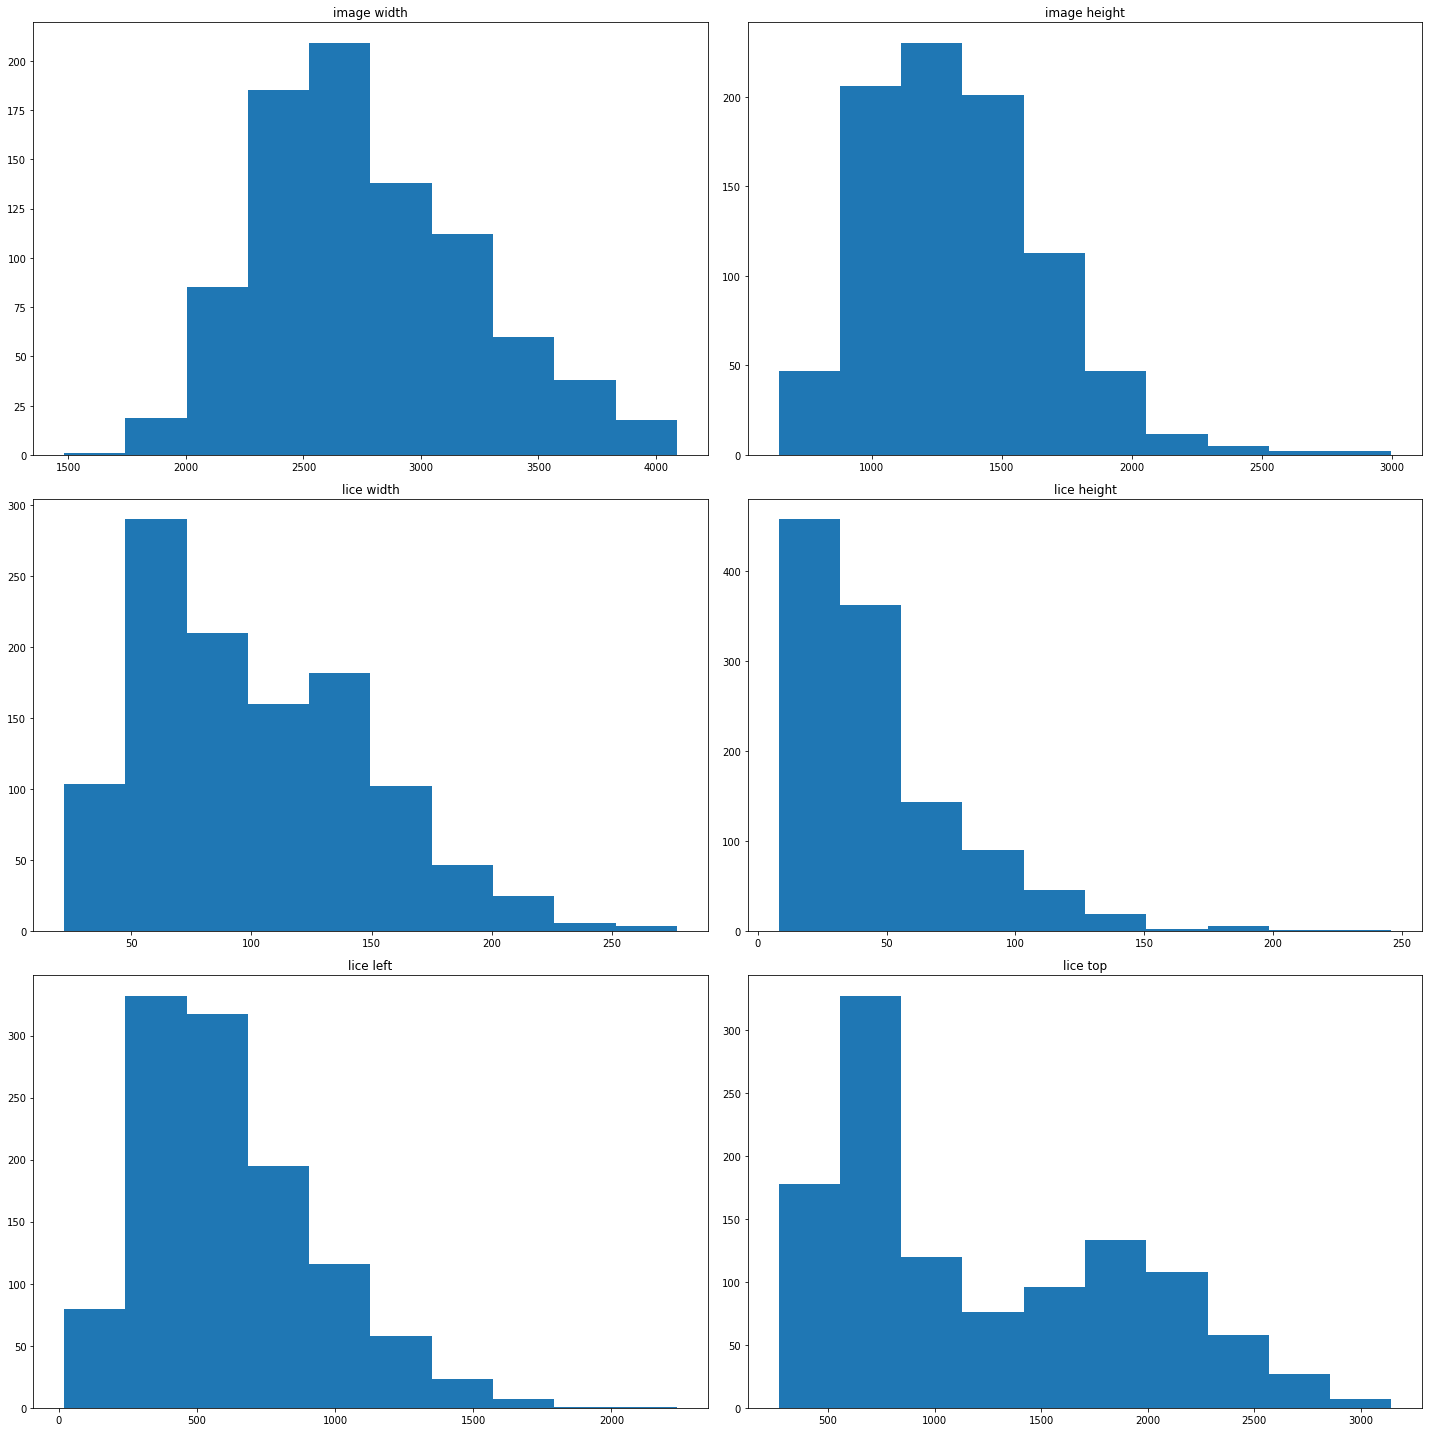

In [29]:


figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))



axes[0, 0].hist(im_width_list, bins=10)
axes[0, 1].hist(im_height_list, bins=10)
axes[0, 0].set_title('image width')
axes[0, 1].set_title('image height')


axes[1, 0].hist(lice_width_list, bins=10)
axes[1, 1].hist(lice_height_list, bins=10)
axes[1, 0].set_title('lice width')
axes[1, 1].set_title('lice height')

axes[2, 1].hist(lice_left_list, bins=10)
axes[2, 0].hist(lice_top_list, bins=10)
axes[2, 0].set_title('lice left')
axes[2, 1].set_title('lice top')

       
figure.tight_layout()

In [50]:
seed(SEED)
for idx, sf_haslice in tqdm(df_ad.iterrows()):

    left_image_f, bucket, left_image_key = s3_access_utils.download_from_url(sf_haslice["left_crop_url"])
    image_f = left_image_f 

    #fig, ax = plt.subplots(figsize=(10, 10)) 
    image = plt.imread(image_f)
    
    image_w = sf_haslice['left_crop_metadata']['width']
    image_h = sf_haslice['left_crop_metadata']['height']
    
    lp = sf_haslice['annotation'][0]['position'] # only take the first female adult
    x, y, w, h = lp["left"], lp["top"], lp["width"], lp["height"]
    
    crop_left_offset = randint(max(0, x + CROP_WIDTH - image_w), min(x, CROP_WIDTH - w))
    crop_top_offset = randint(max(0, y + CROP_HEIGHT- image_h), min(y, CROP_HEIGHT - h))
    
    crop_left = x - crop_left_offset
    crop_top = y - crop_top_offset
    

    
    cropped_image = image[crop_top:(crop_top + CROP_HEIGHT), crop_left:(crop_left + CROP_WIDTH)]
    #ax.imshow( cropped_image)
    
    start, end = "left_frame_crop_", ".jpg"
    s = sf_haslice["left_crop_url"]
    file_name = "left_" + s[s.find(start)+ len(start):s.find(end)]
    
    utils.write_image(cropped_image, file_name, IMAGE_PATH)
    
    #rect = patches.Rectangle((crop_left_offset, crop_top_offset), w, h,linewidth=1,edgecolor="b",facecolor='none')
    
    
    
    xywh = [crop_left_offset, crop_top_offset, w, h]
    bbox = utils.xywh2yolobbox(xywh, [CROP_WIDTH, CROP_HEIGHT])

            
    utils.write_label(0, bbox, file_name, LABEL_PATH)
    
    
    #plt.scatter(bbox[0] * CROP_WIDTH, bbox[1] * CROP_HEIGHT, s=50)
    #ax.add_patch(rect)
plt.show()

865it [02:04,  6.94it/s]


In [45]:
import importlib
importlib.reload(utils)


<module 'utils.utils' from '/root/jane/cv_research/jane/lice_counting/utils/utils.py'>